In [ ]:
#找一下这些cluster都包含几个序列
#chatgpt写的
import os
clstr_file = "/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/04consensus_all_in_one/cdhit/RSV_all_with_ref_986.fasta.clstr"
clusters = []
current_cluster = None

with open(clstr_file, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith(">"):
            if current_cluster is not None:
                clusters.append(current_cluster)

            current_cluster = []
        else:
            sequence_id = line.split(">")[1].split("...")[0]
            status = line.split(">")[1].split("...")[1].strip()  #是不是在去冗余中留下，*是留下了
            current_cluster.append(sequence_id)
            
if current_cluster is not None:
    clusters.append(current_cluster)    
# print(clusters)
#--------------------------------------------------------------------------------------------
dict_cluster_num = {}
for i, cluster in enumerate(clusters):    
    dict_cluster_num[f"Cluster {i}"] = len(cluster)
# print(dict_cluster_num)

dict_cluster_num_sorted = dict(sorted(dict_cluster_num.items(),key = lambda x:x[1]))
# print(dict_cluster_num_sorted)
#--------------------------------------------------------------------------------------------

dict_cluster_id = {}
for i, cluster in enumerate(clusters):  
    dict_cluster_id[f"Cluster {i}"] = cluster
print(dict_cluster_id)

#--------------------------------------------------------------------------------------------
# 看看带星号的序列都有哪些
list_seq_in_tree = []
with open(clstr_file, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith(">"):
            pass
        else:
            sequence_id = line.split(">")[1].split("...")[0]
            status = line.split(">")[1].split("...")[1].strip()    #是不是在去冗余中留下，*是留下了
            if status == '*':
                list_seq_in_tree.append(sequence_id)

# print(len(list_seq_in_tree))

#-------------
#每个cluster都是什么代表的seq
dict_cluster_seq_tree = {}
for k,v in dict_cluster_id.items():
    for i in v:
        if i in list_seq_in_tree:
            dict_cluster_seq_tree[k] = i
# print(dict_cluster_seq_tree)
#-------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------
#把这三个cluster的vcf搞到不同的prj里面去
#先新建目录
selected_cluster_list = ['Cluster 80','Cluster 100','Cluster 108']
for i in selected_cluster_list:
    i_1 = i.replace(' ','_')
    # print(i_1)
    dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{i_1}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        
all_vcf_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/vcf_pair')       

for k,v in dict_cluster_id.items():
    if k in selected_cluster_list:
        k_1 = k.replace(' ','_')
        for a in all_vcf_list:
            a_1 = a.split('.')[0]
            if a_1 in v:
                os.system(f'cp /mnt/alamo01/users/yangjingqi/RSV_sra/group/vcf_pair/{a} /mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{k_1}')


    






In [ ]:
#05 统计bayes的每个样本reads数，写成A256G的形式，过滤，只过滤测序深度,不过滤频率。
#统计每个样本的突变数量
#dp>100并且在至少2个样本中出现过的才算。
#变异类型是snp或者del或ins，这里也筛选了。
#最终输出csv文件。

import csv
import os
import vcf
wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)

for p in os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair'):
    prj_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{p}'
    
    bayes_filenames=os.listdir(prj_path)
    type_list= []
    dict_mut_num = {}#在几个样本中出现过。形成列表，在列表中的才算真正的突变。
    #找出突变在几个样本中出现
    for i in bayes_filenames:
        if i.endswith('vcf'):
            i_1 = i.split('.')[0]
            reads_pos_dict = {}
            path1 = prj_path+'/'+i
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])
    #                 print(af)
                    if dp > 100:
    #                     reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af}
                        if info not in dict_mut_num:
                            dict_mut_num[info] = 1
                        else:
                            dict_mut_num[info] += 1
    #         print(reads_pos_dict)



    filtered_list = []# 测序深度>100且出现在至少2个样本中的突变。
    for k,v in dict_mut_num.items():
        if v > 1:
            filtered_list.append(k)
    # print(filtered_list)


    #根据filtered_list筛选突变，输出csv。
    for i in bayes_filenames:
        if i.endswith('vcf'):
            i_1 = i.split('.')[0]
            reads_pos_dict = {}
            path1 = prj_path +'/'+i
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])    
                    if dp > 100:#即使有列表了也还是需要测序深度>100的这个条件，不然有可能是出现在样本多但是测序深度不行的。
                        if info in filtered_list:
                            if type2 == 'snp' or type2 == 'del' or type2 == 'ins':#筛选变异类型
                                reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af,'sample_exist':dict_mut_num[info]}
    #         print(reads_pos_dict)

            with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample/{p}/{i_1}.csv','w') as f:#表格可以加个频率
                writer = csv.writer(f)
                writer.writerow(["mutation","alt_reads","ref_reads","type","app","allele_frequency","sample_exist'"])
                for k,v in reads_pos_dict.items():
                    writer.writerow([k,v['alt'],v['ref'],v['type'],'freebayes',v['allele_frequency'],v['sample_exist']])

In [ ]:
#04统计突变类型，3%-80%和80%以上的比例，先不管allele frequency，只看次数
#二代测序中3%-80%的突变，对频率有错误影响，对蛋白分布没有影响。可以加一列属于哪个样本的。加上了，次数是准的了。

#80%以下：
import os
import csv

# wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/yjq_sra_bioproject_rsv')
# for i in wenjianjia_list:
#     dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/06product_exist/{i}'
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)

# wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/yjq_sra_bioproject_rsv')
# for i in wenjianjia_list:
#     dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/07mutation_proportion/{i}'
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)

for p in os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample'):
    prj_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample/{p}'

    dict_003_08_next_generation = {}
    for i in os.listdir(prj_path):
        if i.endswith('.csv'):
            csv_path = f'{prj_path}/{i}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        first = row[0].split('_')[0]
    #                     last = row[0].split('_')[2]
    #                     position = row[0].split('_')[1]
                        frequnecy = float(row[5])
                        mutation = row[0]
                        type1 = row[3]
                        if 0.03 <= frequnecy <= 0.8:
    #                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
    #                             dict_003_08_next_generation[mutation] = frequnecy
                            if mutation not in dict_003_08_next_generation.keys():
                                dict_003_08_next_generation[mutation] = {}
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                            else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
    # print(dict_003_08_next_generation)
    # print(p)
# ----------------------------------------------------------------------------------------------------------    
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
    with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist/06isnv_mutation_{p}.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(['isnv','sample','frequency','type'])
        for k,v in dict_003_08_next_generation.items():
            for s,info in v.items():
                frequency = info[0]
                type3 = info[1]
                writer.writerow([k,s.split('.')[0],frequency,type3])
            
#-----------------------------------------------------------------------------------------------------------
    
#统计数量
    dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
    for k,v in dict_003_08_next_generation.items():
        ref = k.split('_')[0]
        alt = k.split('_')[2]
        for s in v.values():
            type2 = s[1]
    #         print(type2)
        if type2 =='snp':
            name = f'{ref}_{alt}'
            add_count = len(v)
        #     print(name)
            for m,c in dict_num_mutation.items():
                if name == m:
                    dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
        if type2 =='del':
            add_count = len(v)

            dict_num_mutation['del'] += add_count
        if type2 =='ins':
            add_count = len(v)

            dict_num_mutation['ins'] += add_count



    print(dict_num_mutation)
    count_all = 0
    for k,v in dict_num_mutation.items():
        count_all += v
    print(count_all)
    
    dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
    for k in dict_proportion.keys():
        dict_proportion[k] = {}
        dict_proportion[k]['count'] = dict_num_mutation[k]
        if count_all!= 0:
            dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
        else:
            dict_proportion[k]['proportion'] = '/'
    print(dict_proportion)  
    with open(f"/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/07mutation_proportion/07isnv_mutation_type_{p}.csv","w") as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerow(['mutation_type','count','proportion','group'])
        for k,v in dict_proportion.items():
            writer.writerow([k,v['count'],v['proportion'],'iSNV'])

        
        
        
        
        
# #-----------------------------------------------------------------------
# #80%上：

    dict_003_08_next_generation = {}
    for i in os.listdir(prj_path):
        if i.endswith('.csv'):
            csv_path = f'{prj_path}/{i}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        first = row[0].split('_')[0]
    #                     last = row[0].split('_')[2]
    #                     position = row[0].split('_')[1]
                        frequnecy = float(row[5])
                        mutation = row[0]
                        type1 = row[3]
                        if  frequnecy > 0.8:
    #                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
    #                             dict_003_08_next_generation[mutation] = frequnecy
                            if mutation not in dict_003_08_next_generation.keys():
                                dict_003_08_next_generation[mutation] = {}
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                            else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]

    #统计数量
    dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
    for k,v in dict_003_08_next_generation.items():
        ref = k.split('_')[0]
        alt = k.split('_')[2]
        for s in v.values():
            type2 = s[1]
    #         print(type2)
        if type2 =='snp':
            name = f'{ref}_{alt}'
            add_count = len(v)
        #     print(name)
            for m,c in dict_num_mutation.items():
                if name == m:
                    dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
        if type2 =='del':
            add_count = len(v)

            dict_num_mutation['del'] += add_count
        if type2 =='ins':
            add_count = len(v)

            dict_num_mutation['ins'] += add_count



    # print(dict_num_mutation)

    #算比例的分母
    count_all = 0
    for k,v in dict_num_mutation.items():
        count_all += v
    # print(count_all)
    dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
    for k in dict_proportion.keys():
        dict_proportion[k] = {}
        dict_proportion[k]['count'] = dict_num_mutation[k]
        if count_all!= 0:
            dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
        else:
            dict_proportion[k]['proportion'] = '/'
    print(dict_proportion)  
    with open(f"/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/07mutation_proportion/07snp_mutation_type_{p}.csv","w") as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerow(['mutation_type','count','proportion','group'])
        for k,v in dict_proportion.items():
            writer.writerow([k,v['count'],v['proportion'],'SNP'])

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
    with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist/06snp_mutation_{p}.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(['isnv','sample','frequency','type'])
        for k,v in dict_003_08_next_generation.items():
            for s,info in v.items():
                frequency = info[0]
                type3 = info[1]
                writer.writerow([k,s.split('.')[0],frequency,type3])
            
            
            

In [ ]:
# 05 翻译蛋白质，要加3-80%的。isnv的
#分批次
#非同义氨基酸突变的具体情况和不同蛋白非同义突变的数量。
#插入加了。
from Bio.Seq import Seq
import os
import pandas as pd


wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/08product_frequency/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
dict_pep_cds = {'99_518':'NS1_1C','628_1002':"NS2_1B",'1140_2315':"N",'2348_3073':"P",'3233_4003':"M",'4274_4468':"SH",'4659_5555':"G",'5632_7356':"F",'7576_8160':"M2",'8468_14965':"L"}

csv_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist')
for c in csv_list:
    if c.endswith('csv'):
        c1 = c.split('_')[3].split('.')[0]
        csv_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist/06isnv_mutation_Cluster_{c1}.csv'
        with open(csv_path) as csvfile:
            dict_info = {}
            info_list = []
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'isnv':
                    mut = row[0]
                    if mut not in info_list:
                        info_list.append(mut)
        dict_info = dict.fromkeys(info_list)


        for i in dict_info.keys():#嵌套字典可以这样赋值：1、dict_info = dict.fromkeys(info_list)2、每个键都赋值成空字典，再正常加就好了
            dict_info[i] = {}


    #----------------
    #新加的，统计每个突变的样本数量。
        df = pd.read_csv(csv_path)
        df_counts = df.isnv.value_counts()
        #print(df_counts)
        outputpath=f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist/mut_sample_number/Cluster_{c1}_mut_sample_number.csv'
        df_counts.to_csv(outputpath,sep=',',index=True,header=False)

        dict_mut_num = {}
        
        mut_number_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/06product_exist/mut_sample_number/Cluster_{c1}_mut_sample_number.csv'
        with open(mut_number_path) as csvfile:
            csv_reader = csv.reader(csvfile) 
            for row in csv_reader:
                isnv = row[0]
                num = row[1]
                dict_mut_num[isnv] = num
        # print(dict_mut_num)


    #--------------
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'isnv':
                    mut = row[0]
                    pos = int(row[0].split('_')[1])
                    fre = float(row[2])
                    type4 = row[3]
                    first = row[0].split('_')[0]
                    last = row[0].split('_')[2]
                    #分一下位置，del和ins的有可能结束位置和开始位置不在同一段蛋白里面。不太可能
                    if type4 == 'del':#按照突变前的长度算
                        pos_end = pos + len(first) -1
                    if type4 == 'ins':#按照突变后的长度算
                        pos_end = pos + len(last) -1          
                    for k,v in dict_pep_cds.items():
                        start = int(k.split('_')[0])
                        end = int(k.split('_')[1])
                        if type4 == 'snp':
                            if start <= pos <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                                dict_info[mut]['product'] = v
                                dict_info[mut]['type'] = type4
                                dict_info[mut]['start'] = start
                                dict_info[mut]['end'] = end
                                dict_info[mut]['sample_number'] = dict_mut_num[mut]
        #                         dict_info[mut]['frequency'] = fre 频率先不考虑了，有好多样本的
                        if type4 == 'del' or type4 == 'ins':
                            if start <= pos <= end and start <= pos_end <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                                dict_info[mut]['product'] = v
                                dict_info[mut]['type'] = type4
                                dict_info[mut]['start'] = start
                                dict_info[mut]['end'] = end
        #                         dict_info[mut]['frequency'] = fre
                                dict_info[mut]['sample_number'] = dict_mut_num[mut]




        # print(dict_info)
        ##---------------------------------------------------------------------------------------
        #去除不在cds范围内的碱基突变                   
        dict_info_feikong = {}            
        for i in dict_info.keys():
            if dict_info[i]:
                dict_info_feikong[i] = dict_info[i]
        # print(dict_info_feikong)

        #获取突变前后的三个碱基，蛋白位置不知道，可以用什么蛋白
        dict_aa_mut = {}#非同义突变的字典
        dict_aa_synonymous_mut = {}
        ref_seq = 'ACGCGAAAAAATGCGTACAACAAACTTGCGTAAACCAAAAAAATGGGGCAAATAAGAATTTGATAAGTACCACTTAAATTTAACTCCCTTGGTTAGAGATGGGCAGCAATTCATTGAGTATGATAAAAGTTAGATTACAAAATTTGTTTGACAATGATGAAGTAGCATTGTTAAAAATAACATGCTATACTGACAAATTAATACATTTAACTAATGCATTGGCTAAGGCAGTGATACATACAATCAAATTGAATGGCATTGTATTTGTGCATGTTATTACAAGTAGTGATATTTGCCCTAATAATAATATTGTAGTGAAATCCAATTTCACAACAATGCCAGTGTTACAAAATGGAGGTTATATATGGGAAATGATGGAATTAACACACTGCTCTCAACCTAATGGCCTAATAGATGACAATTGTGAAATTAAATTCTCCAAAAAACTAAGTGATTCAACAATGACCAATTATATGAATCAATTATCTGAATTACTTGGATTTGATCTTAATCCATAAATTATAATAAATATCAACTAGCAAATCAATGTCACTAACACCATTAGTTAATATAAAACTTGACAGAAGATAAAAATGGGGCAAATAAATCAATTCAGCCGACCCAACCATGGACACAACACACAATGACACCACACCACAAAGACTGATGATCACAGACATGAGACCATTGTCACTTGAGACTATAATAATATCACTAACCAGAGACATCATAACACACAGATTTATATACTTGATAAATCATGAATGTATAGTGAGAAAACTTGATGAAAGACAGGCCACATTTACATTCCTGGTCAACTATGAAATGAAACTATTGCACAAAGTGGGAAGCACTAAATACAAAAAATATACTGAATACAACACAAAATATGGCACTTTTCCTATGCCAATATTTATCAATCATGATGGGTTCTTAGAATGCATTGGCATTAAGCCTACAAAGCACACTCCCATAATATACAAGTATGATCTCAATCCATGAATTTCAACACAAGAGTCACACAATCTGAAATAACAACTTCATGCATAACCACACTCCATAGTTCAAATGGAGCCTGAAAATTATAGTAATTTAAAATTAAGGAGAGACATAAGATGAAAGATGGGGCAAATACAAAAATGGCTCTTAGCAAAGTCAAGTTGAATGATACACTCAACAAAGATCAACTTCTGTCATCCAGCAAATACACCATCCAACGGAGCACAGGAGATAGTATTGATACTCCTAATTATGATGTGCAGAAACACATCAATAAGTTATGTGGCATGTTATTAATCACAGAAGATGCTAATCATAAATTCACTGGGTTAATAGGTATGTTATATGCTATGTCTAGATTAGGAAGAGAAGACACCATAAAAATACTCAGAGATGCGGGATATCATGTAAAAGCAAATGGAGTGGATGTAACAACACATCGTCAAGATATTAATGGGAAAGAAATGAAATTTGAAGTGTTAACATTGTCAAGCTTAACAACTGAAATTCAAATCAACATTGAGATAGAATCTAGAAAATCCTACAAAAAAATGCTAAAAGAAATGGGAGAGGTAGCTCCAGAATACAGGCATGACTCTCCTGATTGTGGGATGATAATATTATGTATAGCGGCATTAGTAATAACCAAATTAGCAGCAGGGGATAGATCTGGTCTTACAGCTGTGATTAGGAGGGCTAATAATGTCCTAAAAAATGAAATGAAACGTTATAAAGGCTTACTACCCAAGGATATAGCCAACAGCTTCTATGAAGTGTTTGAAAAATATCCTCACTTTATAGATGTTTTTGTTCATTTTGGTATAGCACAATCTTCTACCAGAGGTGGCAGTAGAGTTGAAGGGATTTTTGCTGGATTGTTTATGAATGCCTATGGTGCAGGGCAAGTGATGTTACGGTGGGGGGTCTTAGCAAAATCAGTTAAAAATATTATGCTAGGACACGCTAGTGTGCAAGCAGAAATGGAACAAGTTGTGGAGGTTTATGAATATGCCCAAAAATTGGGTGGAGAAGCAGGGTTCTACCATATATTGAACAACCCAAAAGCATCATTATTGTCTTTGACTCAATTTCCTCACTTCTCCAGTGTAGTATTAGGCAATGCTGCTGGCCTAGGCATAATGGGAGAATACAGAGGTACACCAAGGAATCAAGATCTATATGATGCTGCAAAAGCATATGCTGAACAACTCAAAGAAAATGGTGTGATTAACTACAGTGTATTAGACTTGACAGCAGAAGAACTAGAGGCTATCAAACATCAGCTTAATCCAAAAGATAATGATGTAGAGCTTTGAGTTAATAAAAAAAATGGGGCAAATAAAACATCATGGAAAAGTTTGCTCCTGAATTCCATGGAGAAGATGCAAACAACAGAGCTACCAAATTCCTAGAATCAATAAAGGGCAAATTCACATCACCTAAAGATCCCAAGAAAAAAGATAGTATCATATCTGTCAACTCAATAGATATAGAAGTAACCAAAGAAAGCCCTATAACATCAAATTCAACCATTATAAACCCAACAAATGAGACAGATGATACTGTAGGGAACAAGCCCAATTATCAAAGAAAACCTCTAGTAAGTTTCAAAGAAGACCCTACGCCAAGTGATAATCCCTTTTCAAAACTATACAAAGAAACCATAGAAACATTTGATAACAATGAAGAAGAATCTAGCTATTCATATGAAGAAATAAATGATCAGACAAACGATAATATAACAGCAAGATTAGATAGGATTGATGAAAAATTAAGTGAAATACTAGGAATGCTTCACACATTAGTAGTAGCGAGTGCAGGACCTACATCTGCTCGGGATGGTATAAGAGATGCCATGGTTGGTTTAAGAGAAGACATGATAGAAAAAATCAGAACTGAAGCATTAATGACCAATGACAGACTAGAAGCTATGGCAAGACTCAGGAATGAGGAAAGTGAAAAGATGGCAAAAGACACATCAGATGAAGTGTCTCTCAATCCAACATCAGAGAAATTGAACAACCTGTTGGAAGGGAATGATAGTGACAATGATCTATCACTTGATGATTTCTGATCAGTTACCAATCTGTACATCAACACACAACACCAACAGAAGACCAACAAACAAACCAACTCACCCATCCAACCAAACATCTATACGCCAATCAGCCAATCCAAAACTAGCCACCCGGAAAAAATAGATACTATAGTTACAAAAAAAGATGGGGCAAATATGGAAACATACGTGAACAAACTTCACGAAGGCTCCACATACACAGCTGCTGTTCAATACAATGTCTTAGAAAAAGACGATGACCCTGCATCACTTACAATATGGGTGCCCATGTTCCAATCATCCATGCCAGCAGATTTACTTATAAAAGAACTAGCTAATGTCAACATACTAGTGAAACAAATATCCACACCCAATGGACCTTCATTAAGAGTCATGATAAACTCAAGAAGTGCAGTGCTAGCACAAATGCCCAGCAAATTTACCATATGTGCCAATGTGTCCTTGGATGAAAGAAGCAAGCTGGCATATGATGTAACCACACCCTGTGAAATCAAGGCATGTAGTCTAACATGCCTAAAATCAAAAAATATGTTAACTACAGTTAAAGATCTCACTATGAAAACACTCAACCCAACACATGACATCATTGCTTTATGTGAATTTGAAAATATAGTAACATCAAAAAAAGTCATAATACCAACATACCTAAGATCCATCAGTGTCAGAAATAAAGATCTGAACACACTTGAAAATATAACAACCACTGAATTCAAAAATGCCATCACAAATGCAAAAATCATCCCTTACTCAGGATTACTGTTAGTCATCACAGTGACTGACAACAAAGGAGCATTCAAATACATAAAGCCACAAAGTCAATTTATAGTAGATCTTGGAGCTTACCTAGAAAAAGAAAGTATATATTATGTTACAACAAATTGGAAGCACACAGCTACACGATTTGCAATCAAACCCATGGAAGATTAACCTTTTTCTTCTACATCAGTGAGTTGATTCATACAAACTTTCTACCTACATTCTTCACTTCACCATCATAATCACCAACCCTCTGTGGTTCAACTAATCAAACAAAACCCATCTGGAGCCTCAGATCATCCCAAGTCATTGTTCATCAGATCTAGTACTCAAATAAGTTAATAAAAATATCCACATGGGGCAAATAATCATTGGAGGAAATCCAACTAATCACAATATCTGTCAACATAGACAAGTCAACACGCCAGGCAAAATCAACCAATGGAAAATACATCCATAACAATAGAATTCTCAAGCAAATTCTGGCCTTACTTTACACTAATACACATGATAACAACAATAATCTCTTTGCTAATCATAATCTCCATCATGATTGCAATACTGAACAAACTCTGTGAATATAACGTATTCCATAACAAAACCTTTGAGCTACCAAGAGCTCGAGTCAATACATAGCATTCACCAATCTGATGGCACAAAACAGTAACCTTGCATTTGTAAGTGAACAACCCTCACCTCTTTACAAAACCACATCAACATCTCACCATGCAAGCCATCATCCATATTATAAAGTAGTTAATTAAAAATAATCATAACAATGAACTAAGATATTAAGACTAACAATAACGTTGGGGCAAATGCAAACATGTCCAAAAACAAGGACCAACGCACCACCAAGACACTAGAAAAGACCTGGGACACTCTCAATCATCTATTATTCATATCATCGTGCTTATACAAGTTAAATCTTAAATCTATAGCACAAATCACATTATCCATTCTGGCAATGATAATCTCAACTTCACTTATAATTGCAGCCATCATATTCATAGCCTCGGCAAACCACAAAGTCACACTAACAACTGCAATCATACAAGATGCAACAAGCCAGATCAAGAACACAACCCCAACATACCTCACCCAGAATCCCCAGCTTGGAATCAGCTTCTCCAATCTGTCTGAAACTACATCACAAACCACCACCATACTAGCTTCAACAACACCAAGTGTCAAGTCAACCCTGCAATCCACAACAGTCAAGACCAAAAACACAACAACAACCAAAATACAACCCAGCAAGCCCACCACAAAACAACGCCAAAACAAACCACCAAACAAACCCAATAATGATTTTCACTTTGAAGTGTTCAACTTTGTACCTTGCAGCATATGCAGCAACAATCCAACCTGCTGGGCTATCTGTAAAAGAATACCAAACAAAAAACCTGGAAAGAAAACCACCACCAAGCCCACAAAAAAACCAACCATCAAGACAACCAAAAAAGATCTCAAACCTCAAACCACAAAACCAAAGGAAGTACCTACCACCAAGCCCACAGAAAAGCCAACCATCAACACCACCAAAACAAACATCAGAACTACACTGCTCACCAACAATACCACAGGAAATCCAGAACACACAAGTCAAAAGGGAACCCTCCACTCAACCTCCTCCGATGGCAATCCAAGCCCTTCACAAGTCTATACAACATCCGAGTACCTATCACAACCTCCATCTCCATCCAACACAACAAACCAGTAGTCATTAAAAAGCGTATTATTGCAAAAAGCCATGACCAAATCAACCAGAATCAAAATCAACTCTGGGGCAAATAACAATGGAGTTGCCAATCCTCAAAACAAATGCAATTACCGCAATCCTTGCTGCAGTCACACTCTGTTTTGCTTCCAGTCAAAACATCACTGAAGAATTTTATCAAACAACATGCAGTGCAGTCAGCAAAGGCTATCTTAGTGCTCTAAGAACTGGTTGGTATACTAGTGTTATAACTATAGAATTAAGTAATATCAAGGAAAATAAGTGTAATGGAACAGACGCTAAGGTAAAATTGATAAAACAAGAATTAGATAAATATAAAAGTGCTGTAACAGAATTGCAGTTGCTCATGCAAAGCACACCGGCAACCAACAATCGAGCCAGAAGAGAACTACCAAGGTTTATGAATTATACACTCAACAATACCAAAAATACCAATGTAACATTAAGCAAGAAAAGGAAAAGAAGATTTCTTGGCTTTTTGTTAGGTGTTGGATCTGCAATCGCCAGTGGCATTGCTGTATCTAAGGTCCTGCACCTAGAAGGGGAAGTGAACAAAATCAAAAGTGCTCTACTATCCACAAACAAGGCTGTAGTCAGCTTATCAAATGGAGTTAGTGTCTTAACCAGCAAAGTGTTAGACCTCAAAAACTATATAGATAAACAGTTGTTACCTATTGTGAACAAGCAAAGCTGTAGCATATCAAACATTGAAACTGTGATAGAGTTCCAACAAAAGAACAACAGACTACTAGAGATTACCAGGGAATTTAGTGTTAATGCAGGTGTAACTACACCTGTAAGCACTTATATGTTAACAAATAGTGAATTATTATCATTAATCAATGATATGCCTATAACAAATGATCAGAAAAAGTTAATGTCCAACAATGTTCAAATAGTTAGACAGCAAAGTTACTCTATCATGTCCATAATAAAGGAGGAAGTCTTAGCATATGTAGTACAATTACCACTATATGGTGTAATAGATACACCTTGTTGGAAACTGCACACATCCCCTCTATGTACAACCAACACAAAGGAAGGGTCCAACATCTGTTTAACAAGAACCGACAGAGGATGGTACTGTGACAATGCAGGATCAGTATCTTTCTTCCCACTAGCTGAAACATGTAAAGTTCAATCGAATCGAGTATTTTGTGACACAATGAACAGTTTAACATTACCAAGTGAAGTAAATCTCTGCAACATTGACATATTCAACCCCAAATATGATTGCAAAATTATGACTTCAAAAACAGATGTAAGCAGCTCCGTTATCACATCTCTAGGAGCCATTGTGTCATGCTATGGCAAAACTAAATGTACAGCATCCAATAAAAATCGTGGAATCATAAAGACATTTTCTAACGGGTGCGATTATGTATCAAATAAGGGGGTTGACACTGTGTCTGTAGGTAATACATTATATTATGTAAATAAGCAAGAAGGCAAAAGTCTCTATGTAAAAGGTGAACCAATAATAAATTTCTATGACCCATTAGTGTTCCCCTCTGATGAATTTGATGCATCAATATCTCAAGTCAATGAGAAGATTAACCAGAGCCTAGCATTTATTCGTAAATCCGATGAATTATTACATAATGTAAATGCTGGTAAATCCACCATAAATATCATGATAACTACTATAATTATAGTGATTATAGTAATATTGTTATCATTAATTGCCGTTGGACTGCTCCTATACTGCAAGGCCAGAAGCACACCAGTCACACTAAGCAAGGATCAACTGAGTGGTATAAATAATATTGCATTTAGTAACTAAATAAAAATAGCACCTAATCATGTTCTTACAATGGTTTCATATCTGCTCATAGACAACCCATCTATCATTGGATTTTCTTAAAATCTGAACTTCATCGAAACTCTCATCTATAAACCATCTCACTTACATTATTTAAGTAGATTCCTAGTTTATAGTTATATAAAACAATTGAATACCAGATTAACTTACTATTTGTAAAAAATGAGAACTGGGGCAAATATGTCACGAAGGAATCCTTGCAAATTTGAAATTCGAGGTCATTGCTTGAATGGTAAGAGGTGTCATTTTAGTCATAATTATTTTGAATGGCCACCCCATGCACTGCTTGTAAGACAAAACTTTATGTTAAACAGAATACTTAAGTCTATGGATAAAAGCATCGATACTTTATCAGAAATAAGTGGAGCTGCAGAGTTGGACAGAACAGAAGAGTATGCCCTCGGTGTAGTTGGAGTGCTAGAGAGTTATATAGGATCTATAAATAATATAACTAAACAATCAGCATGTGTTGCCATGAGCAAACTCCTCACTGAACTCAACAGTGATGACATCAAAAAACTGAGGGACAATGAAGAGCCAAATTCACCCAAGATAAGAGTGTACAATACTGTCATATCATATATTGAAAGCAACAGGAAAAACAATAAACAAACTATCCATCTGTTAAAAAGATTGCCAGCAGACGTATTGAAGAAAACCATAAAAACCACATTGGATATCCACAAGAGCATAACCATCAATAACCCAAAAGAATCAACTGTTAGTGATATAAACGACCATGCCAAAAATAATGATACTACCTGACAAATATCCTTGTAGTATAAATTCCATACTAATAACAAGTAGTTGTAGAGTTACTATGTATAATCAAAAGAACACACTATATTTCAATCAAAACAACCAAAATAACCATATATACTCACCGAATCAACCATTCAATGAAATCCATTGGACCTCTCAAGACTTGATTGATGCAATTCAAAATTTTCTACAACATCTAGGTATTACTGATGATATATACACAATATATATATTAGTGTCATAACACTCAATCCTAATGCTTACCACATCATCAAACTATTAACTCAAACAATTCAAGCCATGGGACAAAATGGATCCCATTATTAATGGAAATTCTGCTAATGTGTATCTAACCGATAGTTATTTAAAAGGTGTTATTTCTTTCTCAGAATGTAATGCTTTAGGAAGTTACATATTCAATGGTCCTTATCTCAAAAATGATTATACCAACTTAATTAGTAGACAAAATCCATTAATAGAACACATAAATCTAAAGAAACTAAATATAACACAGTCCTTAATGTCTAAGTATCATAAAGGTGAAATAAAAATAGAAGAACCTACTTATTTTCAGTCATTACTTATGACATACAAGAGTATGACCTCGTTAGAACAGATTACTACCACTAATTTACTTAAAAAGATAATAAGAAGAGCTATAGAAATTAGTGATGTCAAAGTCTATGCTATATTGAATAAACTGGGGCTTAAAGAAAAAGACAAGATTAAATCCAACAATGGACAAGATGAAGACAACTCAGTTATTACAACCATAATCAAAGATGATATACTTTTAGCTGTTAAGGATAATCAATCTCATCTTAAAGCAGTCAAAAATCACTCTACAAAACAAAAAGATACAATCAAAACAACACTCTTGAAGAAATTAATGTGTTCAATGCAACATCCTCCATCATGGTTAATACATTGGTTTAATTTATACACAAAATTAAACAACATATTAACACAGTATCGATCAAGTGAGGTAAAAAACCATGGTTTTATATTGATAGACAATCATACTCTCAATGGATTCCAATTTATTTTGAATCAATATGGTTGTATAGTTTATCATAAGGAACTCAAAAGAATTACTGTGACAACCTATAATCAATTCTTGACATGGAAAAATATTAGCCTTAGTAGATTAAATGTTTGTTTAATTACATGGATTAGTAACTGTTTGAACACATTAAATAAAAGCTTAGGCTTAAGATGCGGATTCAATAATGTTATCTTGACACAACTATTCCTCTATGGAGATTGTATACTAAAACTATTCCACAATGAGGGGTTCTACATAATAAAAGAGGTAGAGGGATTTATTATGTCTCTAATTTTAAATATAACAGAAGAAGATCAATTCAGAAAACGGTTTTATAATAGTATGCTCAACAACATCACAGATGCTGCTAATAAAGCTCAGAAAAATCTGCTATCAAGAGTATGTCATACATTATTAGATAAGACAGTATCCGATAATATAATAAATGGCAGATGGATAATTCTATTAAGTAAGTTCCTTAAATTAATTAAGCTTGCAGGTGACAATAACCTTAACAATCTGAGTGAATTATATTTTTTGTTCAGAATATTTGGACACCCAATGGTAGATGAAAGACAAGCCATGGATGCTGTTAAAGTTAATTGCAACGAGACCAAATTTTACTTGTTAAGCAGTTTGAGTATGTTAAGAGGTGCCTTTATATATAGAATTATAAAAGGATTTGTAAATAATTACAACAGATGGCCTACTTTAAGGAATGCTATTGTTTTACCCTTAAGATGGTTAACTTACTATAAACTAAACACTTATCCTTCCTTGTTGGAACTTACAGAAAGAGATTTGATTGTTTTATCAGGACTACGTTTCTATCGTGAGTTTCGGTTGCCTAAAAAAGTGGATCTTGAAATGATCATAAATGATAAGGCTATATCACCTCCTAAAAATTTGATATGGACTAGTTTCCCTAGAAATTATATGCCGTCACACATACAAAATTATATAGAACATGAAAAATTAAAATTTTCCGAGAGTGATAAATCAAGAAGAGTATTAGAGTACTATTTAAGAGATAACAAATTCAATGAATGTGATTTATACAACTGTGTAGTTAATCAAAGTTATCTTAACAACCCTAATCATGTGGTATCTTTGACAGGCAAAGAAAGAGAACTCAGTGTAGGTAGAATGTTTGCAATGCAACCAGGAATGTTCAGACAAGTTCAAATATTAGCAGAGAAAATGATAGCTGAAAACATTTTACAATTCTTTCCTGAAAGTCTTACAAGATATGGTGATCTAGAACTACAGAAAATATTAGAATTGAAAGCAGGAATAAGTAACAAATCAAATCGTTACAATGATAATTACAACAATTACATTAGTAAGTGCTCTATCATCACAGATCTCAGCAAATTCAATCAAGCATTTCGATATGAAACATCATGTATTTGTAGTGATGTACTGGATGAACTGCATGGTGTACAATCTCTATTTTTCTGGTTACATTTAGCTATTCCTCATGTCACAATAATATGCACATATAGGCATGCACCCCCCTATATAAGAGATCATATTGTAGATCTTAACAATGTAGATGAACAAAGTGGATTATATAGATATCATATGGGTGGTATCGAAGGGTGGTGTCAAAAACTATGGACCATAGAAGCTATATCACTATTGGATCTAATATCTCTCAAAGGGAAATTCTCAATTACTGCTTTAATTAATGGTGACAATCAATCAATAGATATAAGTAAACCAGTCAGACTCATGGAAGGTCAAACTCATGCTCAAGCAGATTATTTGCTAGCATTAAATAGTCTTAAATTACTGTATAAAGAGTATGCAGGCATAGGCCACAAATTAAAAGGAACTGAGACTTATATATCAAGAGATATGCAATTTATGAGTAAAACAATTCAACATAACGGTGTATATTACCCAGCTAGTATAAAGAAAGTCCTAAGAGTGGGACCGTGGATAAACACTATACTTGATGATTTCAAAGTGAGTCTAGAATCTATAGGTAGTTTGACACAAGAATTAGAATATAGAGGAGAAAGTCTATTATGCAGTTTAATATTTAGAAATGTATGGTTATATAATCAAATTGCTTTACAACTAAAAAATCATGCATTATGTAACAATAAATTATATTTGGACATATTAAAGGTTCTGAAACACTTAAAAACCTTTTTTAATCTTGATAATATTGATACAGCATTAACATTGTATATGAATTTGCCCATGTTATTTGGTGGTGGTGATCCCAACTTGTTATATCGAAGTTTCTATAGAAGAACTCCTGATTTCCTCACAGAGGCTATAGTTCACTCTGTGTTCATACTTAGTTATTATACAAACCATGATTTAAAAGATAAACTTCAAGATCTGTCAGATGATAGATTGAATAAGTTCTTAACATGCATAATCACATTTGACAAAAACCCTAATGCTGAATTCGTAACATTGATGAGAGATCCTCAAGCTTTAGGGTCTGAGAGACAAGCTAAAATTACTAGCGAAATCAATAGACTGGCAGTTACTGAGGTTTTGAGCACAGCTCCAAACAAAATATTCTCCAAAAGTGCACAACACTATACCACTACAGAGATAGATCTAAATGATATTATGCAAAATATAGAACCTACATATCCTCACGGGCTAAGAGTTGTTTATGAAAGTTTACCCTTTTATAAAGCAGAGAAAATAGTAAATCTTATATCCGGTACAAAATCTATAACTAACATACTGGAAAAGACTTCTGCCATAGACTTAACAGATATTGATAGAGCCACTGAGATGATGAGGAAAAACATAACTTTGCTTATAAGGATATTTCCATTAGATTGTAACAGAGATAAAAGGGAAATATTGAGTATGGAAAACCTAAGTATTACTGAATTAAGCAAATATGTTAGGGAAAGATCTTGGTCTTTATCCAATATAGTTGGTGTTACATCACCTAGTATCATGTATACAATGGACATCAAATATACAACAAGCACTATAGCTAGTGGCATAATCATAGAGAAATATAATGTTAACAGTTTAACACGTGGTGAGAGAGGACCCACTAAACCATGGGTTGGTTCATCTACACAAGAGAAAAAAACAATGCCAGTTTATAATAGACAAGTTTTAACCAAAAAACAGAGAGATCAAATAGATCTATTAGCAAAATTGGATTGGGTGTATGCATCTATAGATAACAAGGATGAATTCATGGAAGAACTTAGCATAGGAATTCTTGGGTTAACATATGAGAAAGCCAAAAAATTATTTCCACAATATTTAAGTGTTAACTATTTGCATCGCCTTACAGTCAGTAGTAGACCATGTGAATTCCCTGCATCAATACCAGCTTATAGAACTACAAATTATCACTTTGATACTAGCCCTATTAATCGCATATTAACAGAAAAGTATGGTGATGAAGATATTGATATAGTATTCCAAAACTGTATAAGCTTTGGCCTTAGCTTAATGTCAGTAGTAGAACAATTTACTAATGTATGTCCTAACAGAATTATTCTTATACCTAAGCTTAATGAGATACATTTAATGAAACCTCCCATATTCACAGGTGATGTTGATATTCACAAGTTAAAACAAGTGATACAAAAACAGCATATGTTTTTACCAGACAAAATAAGTTTGACTCAATATGTGGAATTATTCTTAAGTAATAAAACACTCAAATCTGGATCTCATGTTAATTCTAATTTAATATTGGCGCATAAGATATCTGACTATTTTCATAATACTTACATTTTAAGTACTAATTTAGCTGGACATTGGATTCTGATTATACAACTTATGAAAGATTCTAAGGGTATTTTTGAAAAAGATTGGGGAGAGGGATATATAACTGATCATATGTTCATTAATTTGAAAGTTTTCTTCAATGCTTATAAGACCTATCTCTTGTGTTTTCATAAAGGTTACGGCAGAGCAAAGCTGGAGTGTGATATGAATACTTCAGATCTCCTATGTGTATTGGAATTAATAGACAGTAGTTATTGGAAGTCTATGTCTAAGGTATTTTTAGAACAAAAAGTTATCAAATACATTCTTAGCCAGGATGCAAGTTTACATAGAGTAAAAGGATGTCATAGCTTCAAACTATGGTTTCTTAAACGTCTTAATGTAGCAGAATTCACAGTTTGCCCTTGGGTTGTTAACATAGATTATCATCCAACACATATGAAAGCAATATTAACTTATATAGATCTTGTTAGAATGGGATTGATAAATATAGATAAAATATACATTAAAAATAAACACAAATTCAATGATGAATTTTATACTTCTAATCTCTTTTACATTAATTATAACTTCTCAGATAATACTCATCTATTAACTAAACATATAAGGATTGCTAATTCTGAATTAGAAAATAATTACAACAAATTATATCATCCTACACCAGAAACCCTAGAAAATATACTAACCAATCCGGTTAAATGTAATGACAAAAAGACACTGAATGACTATTGTATAGGTAAAAATGTTGACTCAATAATGTTACCATTGTTATCTAATAAGAAGCTTATTAAATCGCCTACAATGATTAGAACCAATTACAGCAAACAAGATTTGTATAATTTATTTCCTACGGTTGTGATTGATAAAATTATAGATCATTCAGGTAATACAGCCAAATCTAACCAACTTTACACTACTACTTCTCATCAAATACCTTTAGTGCACAATAGCACATCACTTTATTGCATGCTTCCTTGGCATCATATTAATAGATTCAATTTTGTATTTAGTTCTACAGGTTGTAAAATTAGTATAGAGTATATTTTAAAAGACCTTATAATTAAAGATCCTAATTGTATAGCATTCATAGGTGAAGGAGCAGGGAATTTATTATTGCGTACAGTAGTGGAACTTCATCCCGATATAAGATATATTTACAGAAGTCTGAAGGATTGCAATGATCATAGTTTACCTATTGAGTTTTTAAGGCTGTACAATGGACATATCAACATTGATTATGGTGAAAATTTGACCATTCCTGCTACAGATGCAACCAACAACATTCATTGGTCTTATTTACATATAAAGTTTGCTGAACCTATCAGTCTTTTTGTCTGTGATGCTGAATTGCCTGTAACAGTCAACTGGAGTAAAATTATAATAGAGTGGAGCAAGCATGTAAGAAAATGCAAGTACTGTTCCTCAGTTAATAAATGTACGTTAATAGTAAAATATCATGCTCAAGATGATATCGATTTCAAATTAGACAATATAACTATATTAAAAACTTATGTATGCTTAGGCAGTAAGTTAAAGGGGTCTGAAGTTTACTTAGTCCTTACAATAGGTCCTGCAAATGTGTTCCCAGTATTTAATGTAGTACAAAATGCTAAATTGATACTATCAAGAACCAAAAATTTCATCATGCCTAAGAAGGCTGATAAAGAGTCTATTGATGCAAATATTAAAAGTTTGATACCCTTTCTTTGTTACCCTATAACAAAAAAAGGAATTAATACTGCATTGTCAAAACTAAAGAGTGTTGTTAGTGGAGATATACTATCATATTCTATAGCAGGACGTAATGAAGTTTTCAGCAATAAACTTATAAATCATAAGCATATGAACATCTTAAAATGGTTCAATCATGTTTTAAATTTCAGATCAACAGAACTAAACTATAATCATTTATATATGGTAGAATCTACATATCCTTATCTAAGTGAATTGTTAAACAGCTTGACAACTAATGAACTTAAAAAACTGATTAAAATCACAGGTAGTTTGTTATACAACTTTCATAATGAATAATGAATAAAAATCTTATATTAAAAATTCCCATAGCTACACACTAACACTGTATTCAATTATAGTTATTTAAAATTAAAAATTATATAATTTTTTAATAACTTTTAGTGAACTAATCCTAAAATTATCATTTTGATCTAGGAGGAATAAATTTAAATCCAAATCTAATTGGTTTATATGTATATTAACTAAACTACGAGATATTAGTTTTTGACACTTTTTTTCTCGT'
        ref_seq_list = list(ref_seq)
        dict_jianji = {}
        for k,v in dict_info_feikong.items():
            gene_pos = int(k.split('_')[1])
            ref = k.split('_')[0]
            alt = k.split('_')[2]
            product = v['product']
        #     frequency = v['frequency']
            gene_pos_f2 = gene_pos - 2   #前面2个
            gene_pos_f1 = gene_pos - 1   #前面1个
            gene_pos_b1 = gene_pos + 1
            gene_pos_b2 = gene_pos + 2
            start = v['start']
            end = v['end']
            type4 = v['type']
            chazhi = int(gene_pos) - int(start)
            quzheng =  chazhi//3   #取整，以获取是这个蛋白质的第几个氨基酸。
            aa_pos = quzheng + 1

        # #分类讨论
            if type4 == 'del' or type4 == 'ins':
                del_count = len(ref) - len(alt)
                if del_count%3 == 0:
                    #分类讨论
                    #1
                    if chazhi%3 == 2 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])
                   #2
                    if chazhi%3 == 2 and len(alt)%3 == 1:
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])

                    #3
                    if chazhi%3 == 2 and len(alt)%3 == 0:
                    #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])

                    #4
                    if chazhi%3 == 1 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)


                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])

                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])

                    #5
                    if chazhi%3 == 1 and len(alt)%3 == 1:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                #6
                    if chazhi%3 == 1 and len(alt)%3 == 0:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)


                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])

                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])

                    #7
                    if chazhi%3 == 0 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian]) 
                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])

                    #8
                    if chazhi%3 == 0 and len(alt)%3 == 1:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])
                #9
                    if chazhi%3 == 0 and len(alt)%3 == 0:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])

                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])



          #------------------------原来的，底下可以不变  
            if type4 == 'snp':
                if chazhi%3 == 2:
                    list_jianji_pos = []#是位置不是切片，切片要-1
                    list_jianji_pos.append(gene_pos_f2)
                    list_jianji_pos.append(gene_pos_f1)
                    list_jianji_pos.append(gene_pos)



                if chazhi%3 == 1:
                    list_jianji_pos = []
                    list_jianji_pos.append(gene_pos_f1)
                    list_jianji_pos.append(gene_pos)
                    list_jianji_pos.append(gene_pos_b1)



                if chazhi%3 == 0:
                    list_jianji_pos = []
                    list_jianji_pos.append(gene_pos)
                    list_jianji_pos.append(gene_pos_b1)
                    list_jianji_pos.append(gene_pos_b2)


                list_jianji_qiepian = []#这个是切片
                for i in list_jianji_pos:
                    i_1 = i-1
                    list_jianji_qiepian.append(i_1)
            #     print(list_jianji_qiepian)

                list_jianji_ref = []#获取参考碱基
                for i in list_jianji_qiepian:
                    list_jianji_ref.append(ref_seq_list[i])
            #     print(list_jianji_ref)

                #获取alt碱基
                list_jianji_alt= []#获取参考碱基
                for i in list_jianji_qiepian:
                    if i == int(gene_pos - 1):
                        list_jianji_alt.append(alt)
                    else:
                        list_jianji_alt.append(ref_seq_list[i])
            #     print(list_jianji_alt)
            #翻译蛋白质
            str_ref = "".join(list_jianji_ref)
            str_alt = "".join(list_jianji_alt)
            aa_ref = str(Seq(str_ref).translate())
            aa_alt = str(Seq(str_alt).translate())    
            #非同义：
            if aa_alt != aa_ref:
                info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
                dict_aa_mut[k] = {}
                dict_aa_mut[k]['product'] = dict_info_feikong[k]['product']
                dict_aa_mut[k]['aa'] = info
                dict_aa_mut[k]['num'] = dict_mut_num[k]
            #同义
            if aa_alt == aa_ref:
                info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
                dict_aa_synonymous_mut[k] = {}
                dict_aa_synonymous_mut[k]['product'] = dict_info_feikong[k]['product']
                dict_aa_synonymous_mut[k]['aa'] = info
                dict_aa_synonymous_mut[k]['num'] = dict_mut_num[k]
        #             dict_aa_mut[k]['frequency'] = dict_info_feikong[k]['frequency']

        # 

        #非同义----------------------------------------------------------------------
        #统计各个突变的频率。
        with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/08product_frequency/Cluster_{c1}/08isnv_nonsynonymous_mut_frequency.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['isnv','product','aa_mutation','sample_number'])
            for k,v in dict_aa_mut.items():
                writer.writerow([k,v['product'],v['aa'],v['num']])


        #统计非同义突变在哪个蛋白上nonsynonymous mutation
        list_product = []
        for k,v in dict_aa_mut.items():
                if v['product'] not in list_product:
                    list_product.append(v['product'])
                    dict_product = dict.fromkeys(list_product)#每个蛋白上非同义突变的个数
        for k in dict_product.keys():
            dict_product[k] = 0
        for m,p in dict_aa_mut.items():
            for k,v in dict_product.items():
                if p['product'] == k:
                    dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
        # print(dict_product)
        dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
        # print(dict_product)
        with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/08product_frequency/Cluster_{c1}/08isnv_nonsynonymous_product_number.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['product','number','group'])
            for k,v in dict_product.items():
                writer.writerow([k,v,'nonsynonymous'])


        #同义----------------------------------------------------------------------
        #统计各个突变的频率。
        with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/08product_frequency/Cluster_{c1}/08isnv_synonymous_mut_frequency.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['isnv','product','aa_mutation','sample_number'])
            for k,v in dict_aa_synonymous_mut.items():
                writer.writerow([k,v['product'],v['aa'],v['num']])



        #统计同义突变在哪个蛋白上
        list_product = []
        for k,v in dict_aa_synonymous_mut.items():
                if v['product'] not in list_product:
                    list_product.append(v['product'])
                    dict_product = dict.fromkeys(list_product)
        for k in dict_product.keys():
            dict_product[k] = 0
        for m,p in dict_aa_synonymous_mut.items():
            for k,v in dict_product.items():
                if p['product'] == k:
                    dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
        # print(dict_product)
        dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
        # print(dict_product)
        with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/08product_frequency/Cluster_{c1}/08isnv_synonymous_product_number.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['product','number','group'])
            for k,v in dict_product.items():
                writer.writerow([k,v,'synonymous'])

['99_518', '628_1002', '1140_2315', '2348_3073', '3233_4003', '4274_4468', '4659_5555', '5632_7356', '7576_8160', '8468_14965']
['G', 'A', 'T', 'C', 'CAACA', 'TAACA', 'CATCC', 'TATCC', 'CATCCAACCA', 'TATCCAACCA', 'GGC', 'AGC', 'ACCTCA', 'ACCTGA', 'CA', 'GA', 'GAAT', 'GAAC', 'CC', 'TC', 'TGA', 'TGG', 'TACAT', 'TATAT', 'ACAT', 'ATAT', 'CACAAACCACCA', 'CACAAACCACCG', 'TGT', 'TGC', 'ATA', 'AA', 'ACA', 'CAT', 'TAT', 'CAAACCACCA', 'CAAACCACCG', 'CCC', 'CCT', 'GG', 'ACCACCA', 'ACCACCG', 'TAAAAA', 'TCAAAA', 'ATG', 'AG', 'GTG', 'TAAAAATT', 'TAAAAAATT', 'TAAAAATTC', 'TAAAAAATTC', 'CTATGT', 'CTATGC', 'AAACCACCA', 'AAACCACCG', 'CCTCA', 'CCTGA', 'GT', 'GC', 'TAAAAAAAATG', 'TAAAAAAATG', 'TAAAAAAAATGG', 'TAAAAAATGG', 'ACAAACCACCA', 'ACAAACCACCG', 'ATCC', 'ATCA', 'AGAGATG', 'TGAGATG', 'GAATC', 'GAAATC', 'TTC', 'TTT', 'CT', 'GGA', 'GGG', 'ACCAT', 'ACCCAT', 'TCA', 'ACCAC', 'CTTAA', 'CTTTAA', 'AGGC', 'GAGTATGTTAA', 'GAGTGTGTTAA', 'TCCCTTGGTTAGAGAT', 'TCCTTTGGTTAGAGAT']
{'99_518': 2.0240952234550735, '628

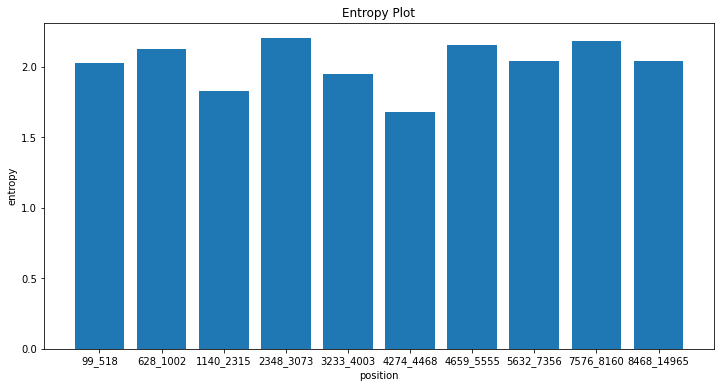

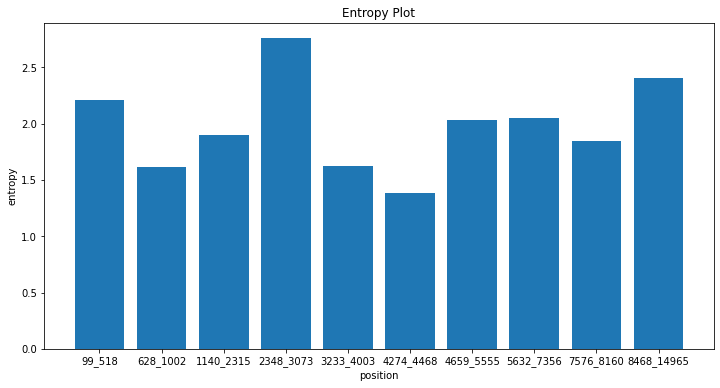

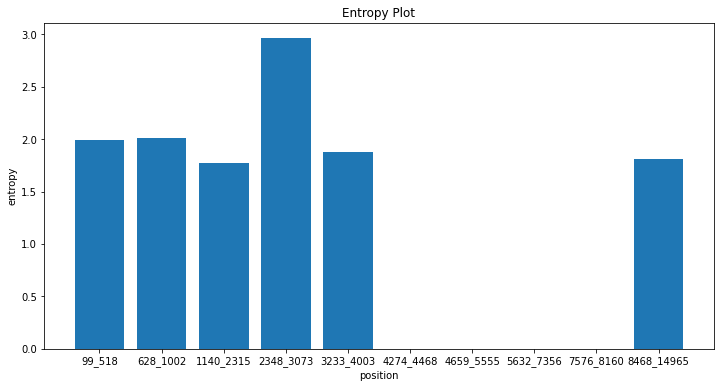

In [39]:
#按照reads计算熵值,画柱状图并且加上所有位点包括没有在vcf里出现的
#熵图分蛋白。
有的=0，再看看。是cluster里确实没有这个蛋白的突变熵就是0



import os
import csv
#新建分组的文件夹
wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/10entropy/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        
        
        
dict_pep_cds = {'99_518':'NS1_1C','628_1002':"NS2_1B",'1140_2315':"N",'2348_3073':"P",'3233_4003':"M",'4274_4468':"SH",'4659_5555':"G",'5632_7356':"F",'7576_8160':"M2",'8468_14965':"L"}
list_pep_cds = list(dict_pep_cds.keys())
print(list_pep_cds)


import csv
import os
import math
import matplotlib.pyplot as plt
prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample')
for i in prj_list:
    list_site_reads_num = []
    prj_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample/{i}'
    csv_list = os.listdir(prj_path)
    for n in csv_list:
        csv_path = f'{prj_path}/{n}'
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'mutation':
                    site_pos = row[0].split('_')[1]
                    ref = row[0].split('_')[0]
                    alt = row[0].split('_')[2]
                    if site_pos not in list_site_reads_num:
                        list_site_reads_num.append(site_pos)
    dict_site_reads_num = dict.fromkeys(list_site_reads_num)
    for k,v in dict_site_reads_num.items():
        dict_site_reads_num[k] = {}

        
        
    for k,v in dict_site_reads_num.items():  
         for n in csv_list:
            csv_path = f'{prj_path}/{n}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        site_pos = row[0].split('_')[1]
                        ref = row[0].split('_')[0]
                        alt = row[0].split('_')[2]
                        ref_num = int(row[2])
                        alt_num = int(row[1])
                        if k == site_pos:
                            if ref not in dict_site_reads_num[k]:
                                dict_site_reads_num[k][ref] = ref_num
                            else:
                                dict_site_reads_num[k][ref] += ref_num
                            if alt not in dict_site_reads_num[k]:
                                dict_site_reads_num[k][alt] = alt_num
                            else:
                                dict_site_reads_num[k][alt] += ref_num
    # print(dict_site_reads_num)
    
    
    list_mutation_kind = []
    for k,v in dict_site_reads_num.items():
        for j,num in v.items():
            if j not in list_mutation_kind:
                list_mutation_kind.append(j)
    print(list_mutation_kind)
    
    dict_each_pep_entropy = dict.fromkeys(list_pep_cds)
    # print(dict_each_pep_entropy)
    for k,v in dict_each_pep_entropy.items():
        dict_each_pep_entropy[k] = dict.fromkeys(list_mutation_kind)
        
    for k,v in dict_each_pep_entropy.items():
        for p,s in v.items():
            dict_each_pep_entropy[k][p] = 0
        
        
    # print(dict_each_pep_entropy)
    for k,v in dict_each_pep_entropy.items():
        if len(v) !=0:
            for y,r in v.items():
                start = k.split('_')[0]
                end = k.split('_')[1]
                for s,p in dict_site_reads_num.items():
                    for j,num in p.items():
                        if int(start) <= int(s) <= int(end):
                            # print(j,y)
                            if j==y:
                                dict_each_pep_entropy[k][j] += num 
    # print(dict_each_pep_entropy)
    
    dict_entropy = {}
    for k,v in dict_each_pep_entropy.items():
        if len(v) !=0:
            each_pep_all_reads = 0
            h_all = 0
            for j in v.keys():
                each_pep_all_reads += dict_each_pep_entropy[k][j]
                # print(each_pep_all_reads)
            if each_pep_all_reads!=0:
                for j in v.keys():
                    p = dict_each_pep_entropy[k][j]/each_pep_all_reads
                    if p!= 0:
                        h = -p*math.log2(p)
                        h_all += h
                dict_entropy[k] = h_all
    print(dict_entropy)
    
    
    dict_entropy_all_pep = dict.fromkeys(list_pep_cds)
    for k,v in dict_entropy_all_pep.items():
        dict_entropy_all_pep[k] = 0
    
    for k,v in dict_entropy_all_pep.items():
        for d,p in dict_entropy.items():
            if k == d:
                dict_entropy_all_pep[k] = dict_entropy[k]
    print(dict_entropy_all_pep)            
        
    # print(i)
    # print(dict_eachsite_entropy)
    list_entropy =list(dict_entropy_all_pep.values())
    list_position = list(dict_entropy_all_pep.keys())
    print(list_entropy)
    print(list_position)
    plt.figure(figsize=(12, 6))
    plt.bar(list_position, list_entropy)
    plt.xlabel('position')
    plt.ylabel('entropy')
    plt.title('Entropy Plot')
    # plt.show()
    plt.savefig(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/11entropy_each_pep/{i}_entropy.pdf')

    
    

In [ ]:
#06频率要5——80%的和上面不同。
# 统计bayes的每个样本reads数，写成A256G的形式，过滤，只过滤测序深度,不过滤频率。
#统计每个样本的突变数量
#dp>100并且在至少2个样本中出现过的才算。
#变异类型是snp或者del或ins，这里也筛选了。
#最终输出csv文件。

import csv
import os
import vcf

wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/02filter_csv_005_08/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        
prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair')
for p in prj_list:
    bayes_filenames=os.listdir(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{p}')
    type_list= []
    dict_mut_num = {}#在几个样本中出现过。形成列表，在列表中的才算真正的突变。
    #找出突变在几个样本中出现
    for i in bayes_filenames:
        if i.endswith('vcf'):
            i_1 = i.split('.')[0]
            reads_pos_dict = {}
            path1 = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{p}/{i}'
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])
    #                 print(af)
                    if dp > 100:
    #                     reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af}
                        if info not in dict_mut_num:
                            dict_mut_num[info] = 1
                        else:
                            dict_mut_num[info] += 1
#         print(reads_pos_dict)



    filtered_list = []# 测序深度>100且出现在至少2个样本中的突变。
    for k,v in dict_mut_num.items():
        if v > 1:
            filtered_list.append(k)
# print(filtered_list)


#根据filtered_list筛选突变，输出csv。
    for i in bayes_filenames:
        if i.endswith('vcf'):
            i_1 = i.split('.')[0]
            reads_pos_dict = {}
            path1 = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/vcf_pair/{p}/{i}'
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])    
                    if dp > 100:#即使有列表了也还是需要测序深度>100的这个条件，不然有可能是出现在样本多但是测序深度不行的。
                        if 0.05<af<0.8:#过滤频率。
                            if info in filtered_list:
                                if type2 == 'snp' or type2 == 'del' or type2 == 'ins':#筛选变异类型
                                    reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af,'sample_exist':dict_mut_num[info]}
        #         print(reads_pos_dict)

            with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/02filter_csv_005_08/{p}/{i_1}.csv','w') as f:#表格可以加个频率
                writer = csv.writer(f)
                writer.writerow(["mutation","alt_reads","ref_reads","type","app","allele_frequency","sample_exist'"])
                for k,v in reads_pos_dict.items():
                    writer.writerow([k,v['alt'],v['ref'],v['type'],'freebayes',v['allele_frequency'],v['sample_exist']])

In [ ]:
#03.1 005_08,mutation_sample heatmap
#去除不包含突变的样本，不画进热图里
#获取所有突变的列表，过滤后的,类型和深度都过滤了。变异类型也过滤了，这部分代码里也有过滤snp,del的（其实不需要了，因为csv里只有snp,del)。
import os
import pandas as pd
import csv

cluster_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/02filter_csv_005_08')
for c in cluster_list:
    cluster_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/02filter_csv_005_08/{c}'


    list_mutation = []
    sample_list = []
    file_bayes_listdir = os.listdir(cluster_path)

    for i in file_bayes_listdir:
        if i.endswith('csv'):
    #         if i.startswith('rsv'):
            # i1 = i.split('.')[0]
            sample_list.append(i)
            path_csv_bayes = f'{cluster_path}/{i}'
            with open(path_csv_bayes) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        list_mutation.append(row[0])
        #         print(list_mutation_eachsample)
    #             for m in list_mutation_eachsample:
    #                 if m not in list_mutation:
    #                     list_mutation.append(m)
    #建立字典，突变对应的样本，0为没有，1为有。
    mutation_sample = dict.fromkeys(list_mutation)#列表转为key
    # print(mutation_sample)
    # print(sample_list)
    for k in mutation_sample.keys():
        mutation_sample[k] = dict.fromkeys(sample_list)
    # print(mutation_sample)
    for i in file_bayes_listdir:
        if i.endswith('csv'):
    #         if i.startswith('rsv'):
            path_csv_bayes = f'{cluster_path}/{i}' 
            df_bayes = pd.read_csv(path_csv_bayes,encoding= 'utf-8')
            list_mutation_eachsample_both = list(df_bayes['mutation'])

            for k in mutation_sample.keys():
                if k in list_mutation_eachsample_both:
                    mutation_sample[k][i] = 1
                else:
                    mutation_sample[k][i] = 0
    # print(mutation_sample)                
    #写入csv
    #第一行去掉.csv
    sample_list1 = []
    for i in sample_list:
        i1 = i.split('.')[0]
        sample_list1.append(i1)
        
    with open(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/05heatmap_isnv/05heatmap_isnv_{c}.csv','w') as f:
        writer = csv.writer(f)
        firstrow = sample_list1
        firstrow.sort()
        firstrow.insert(0,'mutation')#不要加mutation，但是那一个空格要怎么输入呢
        writer.writerow(firstrow)

        for k,v in mutation_sample.items():
            row = []
            row_group = []
            for m in v.keys():
                m1 = m.split('.')[0]
                row.append(m)
                row.sort()
            for n in row:
                row_group.append(v[n])
            row_group.insert(0,k)
            # print(row)
            writer.writerow(row_group)
    ###为什么会有哪个样本中都不存在的突变？因为上面字典名字sra写成bayes了。
    
    
    
    df = pd.read_csv(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/05heatmap_isnv/05heatmap_isnv_{c}.csv')
    df = df.loc[:, (df != 0).any(axis=0)]
    df.to_csv(f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/05heatmap_isnv/without_sample0/05heatmap_isnv_{c}.csv',index=False)



In [37]:
#找cluster是哪个prj  {'Cluster 0': ['SRR7648021', 'SRR7648030'], '
import os
prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/vcf_pair')
dict_cluster_prj = dict.fromkeys(list(dict_cluster_id))
# print(dict_cluster_prj)
for k in dict_cluster_prj.keys():
    dict_cluster_prj[k] = {}
    
    
for i in prj_list:
    prj_path = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/vcf_pair/{i}'
    vcf_list = os.listdir(prj_path)
    sample_list = []
    for n in vcf_list:
        n1 = n.split('.')[0]
        sample_list.append(n1)
    # print(sample_list)
    for k,v in dict_cluster_id.items():
        for s in v:
            if s in sample_list:
                if i not in dict_cluster_prj[k]:
                    dict_cluster_prj[k][i] = 1
                else:
                    dict_cluster_prj[k][i] += 1

    
print(dict_cluster_prj)    



{'Cluster 0': {'PRJNA262901': 2}, 'Cluster 1': {'PRJNA262901': 5}, 'Cluster 2': {'PRJNA438443': 70, 'PRJNA262901': 17}, 'Cluster 3': {'PRJNA438443': 1, 'PRJNA262901': 11}, 'Cluster 4': {'PRJNA438443': 2, 'PRJNA262901': 3}, 'Cluster 5': {'PRJNA438443': 1, 'PRJNA262901': 4}, 'Cluster 6': {'PRJNA262901': 1}, 'Cluster 7': {'PRJNA262901': 1}, 'Cluster 8': {'PRJNA262901': 4}, 'Cluster 9': {'PRJNA262901': 6}, 'Cluster 10': {'PRJNA262901': 1}, 'Cluster 11': {'PRJNA262901': 3}, 'Cluster 12': {'PRJNA262901': 1}, 'Cluster 13': {'PRJNA262901': 2}, 'Cluster 14': {'PRJEB2916': 6}, 'Cluster 15': {'PRJNA262901': 3}, 'Cluster 16': {'PRJEB34042': 2, 'PRJNA438443': 3, 'PRJNA262901': 1}, 'Cluster 17': {'PRJNA262901': 3}, 'Cluster 18': {'PRJEB2916': 1}, 'Cluster 19': {'PRJNA438443': 19, 'PRJEB2916': 3, 'PRJNA262901': 36}, 'Cluster 20': {'PRJNA438443': 1, 'PRJNA262901': 4}, 'Cluster 21': {'PRJNA262901': 3}, 'Cluster 22': {'PRJEB34042': 32, 'PRJNA846693': 1, 'PRJNA438443': 8, 'PRJEB2822': 2, 'PRJNA804555': 5